# Application of Gradient Boosting Machine and Neural Networks to Predict Patient Cancer Survival with Gene Mutation Data and Clinical Survival Data

## Version: Skin Cancer 
#### Please look through Version: Breast Cancer (Notebook 1 first)

###  Washieu Anan

#### Skin cancer survival data from the TCGA holds clues as to what genetic mutations may cause the ultimate fate of patients. In this study, we perform standard survival analysis using  Kaplan Meir Fitter Survival and COX Proportional Hazards, and finally use a gradient boosting model to see if we can predict survival of a patient based on their mutations. Two neural networks will also be applied to determine if neural networks are good classifiers for survival predictions. 

#### IMPORTANT NOTE: This notebook is solely for skin cancer data. For breast cancer data, please refer to notebook 1 in the folder. 

## Loading Data from Genomic Data Commons

The National Cancer Institute runs the Genomic Data Commons (GDC), an extremely thorough repository of genomic and clinical data. This is an indispensable data repository for scientists and offers multiple data formats depending on a study of interest. There are many ways to download data from the GDC.

   1. Download directly from the GDC portal. This is perhaps the easiest way to download data as the website interface is very simple, has many filters to help find data quickly, and is also a good way to visualize data. However, for the purpose of demonstrating how data can be downloaded programmatically, this method will not be employed (except to download the clinical .tar file first). Additionally, in the case of downloading multiple datasets, using the website interface can be tedious. 
   2. Using the GDC client. The GDC has a data download tool that can download multiple datasets if one has a manifest file. A manifest file can be downloaded from the GDC portal after selecting what cancer types, file types, and other features one desires. This is very useful if someone wants to download many clinical and mutation files. 
   3. Using the GDC API. The GDC has built an API that can be used with Python to download any file. The file is downloaded onto the user's computer. The user can then access the file from their computer and load it into a kernel.
    
The method that will be used is (3), the GDC API. Since only 2 cancer types will be examined for the purpose of this project, the API is a good way to download data programmatically. In order to download desired data, UUIDs will be required. A UUID is a special identification number for any file on the GDC repository. This number can be accessed once clicking on a file on the GDC portal. It can also be accessed from a manifest file if one is to download multiple datasets at a time. 

For this project, we will examine two cancer types: Breast and Skin. For each of these cancer types, we will use data collected by the Cancer Genome Atlas project (TCGA). TCGA data is very thorough is used by many bioinformaticians. There are two file types will require for survival analysis and survival prediction: clinical and mutation. The purpose of and data in each file is as follows:

   1. Clinical: clinical files have patient ids (unique alpha-numeric identification key), some patient information like date of birth, vital status (whether patient is alive or dead), days since last follow up or diagnosis, information regarding cancer cells, cancer stage, and information about some possibly related diseases. Many of these files are closed access and can only be obtained if one is given special permission by the NIC. We will only be using open access data. This file does not contain patient's names or locations.

   2. Mutation file: mutation files contain information regarding mutated genes collected from the same patients listed in clinical files. These files have the same patient ids as in clinical files, but focus on mutated genes, site of mutation, type of mutation, region of mutation, and impact of mutation. These datasets are fairly large and contain information regarding some non-relevant mutations. Therefore, some filtering will be employed to only use mutation information for the most prevalent and high impact mutations. 
   
Clinical files can only be retrieved through the portal or by using the GDC client tool. For the purpose of this project, the GDC portal will be used for downloading the clinical files. The mutation files will be downloaded using the API.

In [1]:
'''Import libraries'''

#Essential 
import numpy as np
import requests
import json
import re
import tarfile
import pandas as pd #pandas will help as visualize data
import seaborn as sns #for exploratory data visualization
from matplotlib import pyplot as plt


#Lifelines is a very helpful API for survival analysis. This will help make survival curves.
from lifelines import KaplanMeierFitter
from lifelines import ExponentialFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter

#Machine learning Models
import xgboost as xgb #Gradient Boosting Machine
from sklearn.neural_network import MLPClassifier #Multi-Layer Perceptron 
from keras.models import Sequential #Neural Network
from keras.layers import Dense
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder #for encoding of categorical data

Using TensorFlow backend.


##### Clinical Files

In [2]:
'''Clinical files are stored in .tar files by the GDC. The .tar file needs to be extracted to access the CSV file inside. 
Ensure that .tar files from the GDC are in the same working directory. Each .tar file contains a file named 'clinical.tsv' and
a file named 'exposure.tsv'. Thus, it is important to store each file into a seperate dataframe immediately after untarring.
This will ensure the data for different cancer types don't get mixed up or replace each other.'''


#Skin Cancer Clinical File
#Untarring
skin_tar = tarfile.open("skin_clinical.cases_selection.tar.gz")
skin_tar.extractall()
skin_tar.close()

#Store in dataframe for skin cancer
clinical_file = 'clinical.tsv'
df_skin = pd.read_csv(clinical_file, sep='\t')

In [3]:
df_skin.head(3) #Verify that skin clinical data is stored successfully

,case_id,submitter_id,project_id,cause_of_death,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,...,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,90aa7540-93e7-4ffa-9e77-879198be1e7b,TCGA-ER-A19G,TCGA-SKCM,--,female,1939,white,-17820,alive,--,...,--,--,--,--,Skin of trunk,--,--,--,--,--
1,e35be832-6972-4677-b985-02e90d51141a,TCGA-ER-A3EV,TCGA-SKCM,--,male,1946,white,-20354,dead,1429,...,--,--,--,--,"Lymph node, NOS",--,--,--,--,--
2,f027da44-6adc-4207-93ac-e8bf45a1bf3d,TCGA-FR-A3YN,TCGA-SKCM,--,male,1961,white,-16278,alive,--,...,--,--,--,--,Lymph nodes of inguinal region or leg,--,--,--,--,--


The breast and skin cancer data has been successfully stored in their own respective dataframes. This is clear as indicated by the 'project_id' field in both dataframes shown above. 'TCGA-BRCA' stands for TCGA breast cancer and 'TCGA-SKCM' stands for TCGA skin cancer.

##### Mutation Files

In [4]:
'''Using the GDC's API as well as UUID names for TCGA breast and skin cancer mutation files, mutation data is stored in
the same directory location as this file.'''

pd.set_option('display.max_columns', None) #To see all columns of files in dataframe


#Load Skin Cancer Data    
#Brain Cancer Mutation File
skin_mut_file_id = "4b7a5729-b83e-4837-9b61-a6002dce1c0a" #SKCM UUID
data_endpt = "https://api.gdc.cancer.gov/data/{}".format(skin_mut_file_id)
response = requests.get(data_endpt, headers = {"Content-Type": "application/json"})

# The file name can be found in the header within the Content-Disposition key.
response_head_cd = response.headers["Content-Disposition"]
file_name = re.findall("filename=(.+)", response_head_cd)[0]
with open(file_name, "wb") as output_file:
    output_file.write(response.content)

#Store in pandas dataframe
skin_maf = pd.read_table(file_name, comment='#')    
#Filter the mutation data to get the most prevelant mutations
skin_mut = skin_maf[(skin_maf.FILTER == "PASS") & ((skin_maf.IMPACT == "MODERATE") | (skin_maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria for skin cancer, {:.2f}%".format(
    len(skin_mut), len(skin_maf), 100 * len(skin_mut) / len(skin_maf)))


C:\Users\wr225\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (87,88,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


217691 out of 392571 mutations passed the filtering criteria for skin cancer, 55.45%


In [5]:
skin_mut.head(3) #Verify that skin cancer mutation dataset is stored. 

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
0,CAMTA1,23261,BI,GRCh38,chr1,7663407,7663407,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-ER-A19O-06A-11D-A197-08,TCGA-ER-A19O-10A-01D-A199-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,f1a7c6c6-a7a5-44f1-84d5-59c7a6ef902f,a6eb80d5-a4af-4d88-a201-9130e38ad853,c.860C>T,p.Ser287Leu,p.S287L,ENST00000303635,9/23,129,97,32,113,NaN,NaN,"CAMTA1,missense_variant,p.S287L,ENST0000030363...",T,ENSG00000171735,ENST00000303635,Transcript,missense_variant,missense_variant,1067/8444,860/5022,287/1673,S/L,tCg/tTg,NaN,1,NaN,1.0,CAMTA1,HGNC,HGNC:18806,protein_coding,YES,CCDS30576.1,ENSP00000306522,Q9Y6Y1,NaN,UPI00001C1D72,NM_015215.3,deleterious(0),probably_damaging(0.99),9/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,1.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CATCTCGCCCA,f944eaa8-8260-411c-b875-824f27ab961c,e0e25c3a-0f0c-4d60-b1d5-9938d3e1c4d0,4ba835c3-36e8-4285-bffc-187fa3c048cb,69c0ef46-3117-46f3-b36e-581eb03eb829,NaN,COSM43045,True,Unknown
1,C8B,732,BI,GRCh38,chr1,56956798,56956798,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-ER-A19O-06A-11D-A197-08,TCGA-ER-A19O-10A-01D-A199-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,f1a7c6c6-a7a5-44f1-84d5-59c7a6ef902f,a6eb80d5-a4af-4d88-a201-9130e38ad853,c.362G>A,p.Arg121Gln,p.R121Q,ENST00000371237,3/12,315,242,73,371,NaN,NaN,"C8B,missense_variant,p.R69Q,ENST00000543257,NM...",T,ENSG00000021852,ENST00000371237,Transcript,missense_variant,missense_variant,429/2037,362/1776,121/591,R/Q,cGa/cAa,NaN,1,NaN,-1.0,C8B,HGNC,HGNC:1353,protein_coding,YES,CCDS30730.1,ENSP00000360281,P07358,NaN,UPI000013C9B2,NM_000066.3,tolerated(0.13),benign(0.022),3/12,NaN,PROSITE_profiles:PS50068;SMART_domains:SM00192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,1.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CACATCGCACT,f944eaa8-8260-411c-b875-824f27ab961c,e0e25c3a-0f0c-4d60-b1d5-9938d3e1c4d0,4ba835c3-36e8-4285-bffc-187fa3c048cb,69c0ef46-3117-46f3-b36e-581eb03eb829,NaN,COSM3491224,True,Unknown
3,ARHGAP29,9411,BI,GRCh38,chr1,94188873,94188873,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-ER-A19O-06A-11D-A197-08,TCGA-ER-A19O-10A-01D-A199-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,f1a7c6c6-a7a5-44f1-84d5-59c7a6ef902f,a6eb80d5-a4af-4d88-a201-9130e38ad853,c.1645G>A,p.Glu549Lys,p.E549K,ENST00000260526,15/23,113,81,32,117,NaN,NaN,"ARHGAP29,missense_variant,p.E549K,ENST00000260...",T,ENSG0000013796

All data has been successfully downloaded and stored into seperate, unique dataframes. This proves that clinical and mutation data available on the GDC can be programatically downloaded (with the exception of having to physically download the clinical .tar file from the GDC portal or by using the GDC client). Additionally, the mutation dataset was filtered to find the most prevelant mutations in the list. 

## Skin Cancer Survival Analysis 

The skin cancer data will be studied now. Survival analysis will allow us to see how gene mutations and cancer stage ultimately impact survival of a patient over time. 

In [172]:
'''
Since, we are dealing with skin cancer, we should really focus on the TTN, MUC16, BRAF, DNAH5, and PCLO genes. We can find the mutation 
load of each gene and we will see that the TTN, MUC16, BRAF, DNAH5, and PCLO genes have the highest loads. Within the skin_mut dataframe, 
one can find many column names. Here are some very relevant ones

Hugo_Symbol: name of the gene

Entrez_Gene_id: id of the gene, similar to Hugo_Symbol

case_id: patient case id associated with patients in the clinical file; this will allow us to merge the mutations and clinical
dataframes for each unique patient

Tumor_Sample_Barcode: unique barcode for the dataset
'''

#Let's show the frequency of each unique mutation in our mutation dataset
mutation_frequency_skin = skin_mut.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_skin.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_skin.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
15950,TTN,335
9229,MUC16,306
1515,BRAF,232
4039,DNAH5,228
10818,PCLO,207
8239,LRP1B,177
342,ADGRV1,164
3393,CSMD1,156
12692,RP1,153
8824,MGAM,152


As we can see, the TTN, MUC16, BRAF, DNAH5, and PCLO genes are the most prevenlently mutated genes associated with skin cancer according to this skin cancer mutation file.

In [173]:
'''Not every column in the mutation dataframe is relevant to us. We care about the mutation name and id, as well as the
case id of the patient that mutation. This is because want to see the impact of the gene mutation itself on patient survival
time. Other features can be used from this mutation dataset for future studies.'''

#Let's take parts of the mutation set that are most relevant going forward. Let's store it in a new dataframe called relmut
skin_relmut = skin_mut[['Hugo_Symbol', 'Entrez_Gene_Id', 'case_id', 'Tumor_Sample_Barcode']]
skin_relmut.head()

,Hugo_Symbol,Entrez_Gene_Id,case_id,Tumor_Sample_Barcode
0,CAMTA1,23261,69c0ef46-3117-46f3-b36e-581eb03eb829,TCGA-ER-A19O-06A-11D-A197-08
1,C8B,732,69c0ef46-3117-46f3-b36e-581eb03eb829,TCGA-ER-A19O-06A-11D-A197-08
3,ARHGAP29,9411,69c0ef46-3117-46f3-b36e-581eb03eb829,TCGA-ER-A19O-06A-11D-A197-08
4,LRRC39,127495,69c0ef46-3117-46f3-b36e-581eb03eb829,TCGA-ER-A19O-06A-11D-A197-08
5,NTNG1,22854,69c0ef46-3117-46f3-b36e-581eb03eb829,TCGA-ER-A19O-06A-11D-A197-08


In [174]:
'''Now, lets move onto understanding the clinical file. However, we want to make sure that we analyze patient data for patients
who also show up in the mutation dataset. Otherwise, we may have missing values in some columns for some patients. This may occur
due to our filtering of the mutation dataset for high impact mutations.'''

#You will notice that there are case ids in this mutation file. These case ids correspond to the case ids in our clinical file.
#We want to find the instances in our clinical file that are also part of the mutation file.
cID = skin_relmut.case_id.tolist() #let's store the case ids inside a list
df_skin = df_skin[df_skin['case_id'].isin(cID)] #Now let's filter our clinical file dataframe with the case ids also in relmut
df_skin.head()

,case_id,submitter_id,project_id,cause_of_death,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,ann_arbor_b_symptoms,year_of_diagnosis,classification_of_tumor,last_known_disease_status,method_of_diagnosis,laterality,residual_disease,primary_diagnosis,tumor_stage,age_at_diagnosis,hpv_positive_type,morphology,ann_arbor_clinical_stage,new_event_anatomic_site,days_to_last_known_disease_status,perineural_invasion_present,ajcc_clinical_n,prior_treatment,ajcc_clinical_m,colon_polyps_history,ajcc_pathologic_m,ajcc_pathologic_n,tumor_largest_dimension_diameter,days_to_last_follow_up,ann_arbor_pathologic_stage,days_to_recurrence,tumor_grade,figo_stage,lymphatic_invasion_present,tissue_or_organ_of_origin,progression_or_recurrence,ajcc_clinical_t,hpv_status,prior_malignancy,ajcc_staging_system_edition,vascular_invasion_present,new_event_type,ajcc_pathologic_stage,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,90aa7540-93e7-4ffa-9e77-879198be1e7b,TCGA-ER-A19G,TCGA-SKCM,--,female,1939,white,-17820,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Malignant melanoma, NOS",not reported,17820,--,8720/3,--,--,--,--,--,--,--,--,--,--,--,9188,--,--,not reported,--,--,"Skin, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,Skin of trunk,--,--,--,--,--
1,e35be832-6972-4677-b985-02e90d51141a,TCGA-ER-A3EV,TCGA-SKCM,--,male,1946,white,-20354,dead,1429,not hispanic or latino,2004,--,--,not reported,not reported,--,--,--,"Malignant melanoma, NOS",stage iii,20354,--,8720/3,--,--,--,--,--,--,--,--,--,--,--,1429,--,--,not reported,--,--,"Skin, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Lymph node, NOS",--,--,--,--,--
2,f027da44-6adc-4207-93ac-e8bf45a1bf3d,TCGA-FR-A3YN,TCGA-SKCM,--,male,1961,white,-16278,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Malignant melanoma, NOS",stage ib,16278,--,8720/3,--,--,--,--,--,--,--,--,--,--,--,2828,--,--,not reported,--,--,"Skin, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,Lymph nodes of inguinal region or leg,--,--,--,--,--
3,0153f141-625e-4623-9f8a-296678002c63,TCGA-D3-A3ML,TCGA-SKCM,--,male,1933,white,-25643,dead,422,not hispanic or latino,2004,--,--,not reported,not reported,--,--,--,"Malignant melanoma, NOS",stage iiia,25643,--,8720/3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,not reported,--,--,"Skin, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Lymph nodes of head, face and neck",--,--,--,--,--
4,adfa6beb-1aa3-4a2a-afe7-8d036a80b20d,TCGA-WE-AAA0,TCGA-SKCM,--,male,1964,white,-17261,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Malignant melanoma, NOS",stage ia,17261,--,8720/3,--,--,--,--,--,--,--,--,--,--,--,1229,--,--,not reported,--,--,"Skin, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Lymph node, NOS",--,--,--,--,--


You may notice many columns have missing values or are simply not reported. For suvival analysis, we only really need two pieces of information:

1. Vital status: we need to know if the patient is alive or dead at the conclusion of this study in which this data was collected. 
2. Cancer duration: this is the amount of time that has passed from cancer diagnosis to death ('days_to_death' column) or the amount of time that has passed from the most recent followup appointment ('days_to_last_follow_up' column). We need to consolidate these columns into one 'duration' column. 
3. Tumor stage: since the stage of the tumor at the end of the study is of interest to us for the machine learning portion of the project in which survival prediction will be done, we need to extract that infomration as well.

In [175]:
#As shown in the pandas dataframe for the clinical file, we have multiple fields of information for each patient sample. 
#However, we are particularly interested in the days to death or days to last follow up and the vital status of the patients.
#When we have found those particular fields and isolated them, we can begin to modify the table by simplifying the 
#vital status for the use of survival regression studies.

#Let's modify the data set to only have the particular columns we want
df_skin_1 = df_skin[['case_id', 'vital_status', 'days_to_death', 'days_to_last_follow_up', 'tumor_stage']]
df_skin_1.head()

,case_id,vital_status,days_to_death,days_to_last_follow_up,tumor_stage
0,90aa7540-93e7-4ffa-9e77-879198be1e7b,alive,--,9188,not reported
1,e35be832-6972-4677-b985-02e90d51141a,dead,1429,1429,stage iii
2,f027da44-6adc-4207-93ac-e8bf45a1bf3d,alive,--,2828,stage ib
3,0153f141-625e-4623-9f8a-296678002c63,dead,422,--,stage iiia
4,adfa6beb-1aa3-4a2a-afe7-8d036a80b20d,alive,--,1229,stage ia


In [176]:
#Examine how many patients will be studied
print('Total patients in dataset: ' + str(len(df_skin_1)))

Total patients in dataset: 467


In [177]:
#The days_to_death and days_to_last_follow_up column is our duration information. We want to consolidate that information
#into one duration set. Using pandas column manipulation, we can do just that. Additionally, we should set the vital_status info
#into integers based on dead or alive status. Alive will be a 0, while dead will be a 1.

df2 = df_skin_1 #We want to modify the table but without tampering with it
df2.days_to_death[df2.days_to_death == '--'] = df2.days_to_last_follow_up #Get rid of empty rows in the days_to_death column
df2['duration'] = df2['days_to_death'] #copy all values into one duration column
df3 = df2[['case_id','vital_status', 'duration', 'tumor_stage']] #df3 is the dataframe with our ultimate data
df3.vital_status[df3.vital_status == 'alive'] = 0 #making vital_status into 0 or 1 based on status
df3.vital_status[df3.vital_status == 'dead'] = 1
df3 = df3[df3['duration'] != '--'] #Takes care of any missing duration rows

C:\Users\wr225\Anaconda3\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\wr225\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\wr225\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

In [178]:
#The duration and vital_status needs to be converted to a numeric for further use
df3['duration'] = pd.to_numeric(df3['duration'])
df3['vital_status'] = pd.to_numeric(df3['vital_status'])
df3.head()

,case_id,vital_status,duration,tumor_stage
0,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported
1,e35be832-6972-4677-b985-02e90d51141a,1,1429,stage iii
2,f027da44-6adc-4207-93ac-e8bf45a1bf3d,0,2828,stage ib
3,0153f141-625e-4623-9f8a-296678002c63,1,422,stage iiia
4,adfa6beb-1aa3-4a2a-afe7-8d036a80b20d,0,1229,stage ia


As shown above, the 'duration' field is a consolidated patient survival duration column. This will allow for a simple survival analysis. However, we are interested in survival analysis for patients based on their gene mutation as well. Thus, we will need to now merge the mutation and clinical dataframes.

In [179]:
#We can now find the intersection between the mutation dataset and the clinical file by merging the two based 
#on the case_id field. 
df3 = pd.merge(df3, skin_relmut, on='case_id', how='inner')
df3.head()

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
0,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,CFAP74,85452,TCGA-ER-A19G-06A-11D-A196-08
1,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,PIK3CD,5293,TCGA-ER-A19G-06A-11D-A196-08
2,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,PRAMEF6,440561,TCGA-ER-A19G-06A-11D-A196-08
3,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,PRAMEF14,729528,TCGA-ER-A19G-06A-11D-A196-08
4,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,NKAIN1,79570,TCGA-ER-A19G-06A-11D-A196-08


In [180]:
#Let us confirm using the mutation frequency that the most common genes we should worry about are TP53 and PIK3CA, just
#this time with our combined dataframe with muatation info, duration, and vital_status. As you can see, those two genes
#are still most prevalent.
mutation_frequency_skin = df3.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_skin.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_skin.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
15926,TTN,328
9212,MUC16,298
1514,BRAF,226
4035,DNAH5,222
10801,PCLO,202
8224,LRP1B,172
342,ADGRV1,161
3390,CSMD1,154
12672,RP1,150
656,ANK3,150


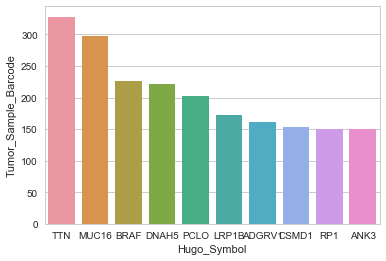

In [181]:
#Let's visualize this to showcase how important each gene probably is compared to other genes in the top 10 most prevelant genes
sns.set(style="whitegrid")
sns.barplot(x = 'Hugo_Symbol', y = 'Tumor_Sample_Barcode', data = mutation_frequency_skin[0:10])

In [182]:
#Just as an extra check, we can even see if those two genes are common amongst patients who passed away.
df3_test_one = df3[df3['vital_status'] == 1]
mutation_frequency_test_one = df3_test_one.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_test_one.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_test_one.head()

,Hugo_Symbol,Tumor_Sample_Barcode
14318,TTN,157
8290,MUC16,133
3645,DNAH5,100
1372,BRAF,99
9761,PCLO,90


In [183]:
#Since we can see that the TTN, MUC16, BRAF, DNAH5, and PCLO genes are the most important genes for skin cancer status, let's filter our
#combined clinical/mutation dataset for cases with these mutations. However, we want to see how a less prevelant gene
#affects patient survival as well so as to highlight the biffer effect of the TTN, MUC16, BRAF, DNAH5, and PCLOA genes on 
#skin cancer patient #survival. 
common = ['TTN', 'MUC16', 'BRAF', 'DNAH5', 'PCLO'] #store the important genes in a list
df3 = df3[df3['Hugo_Symbol'].isin(common)] #filter the dataframe with the two genes inside the list common
df3.head()

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
66,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,TTN,7273,TCGA-ER-A19G-06A-11D-A196-08
67,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,TTN,7273,TCGA-ER-A19G-06A-11D-A196-08
68,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,TTN,7273,TCGA-ER-A19G-06A-11D-A196-08
69,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,TTN,7273,TCGA-ER-A19G-06A-11D-A196-08
104,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,DNAH5,1767,TCGA-ER-A19G-06A-11D-A196-08


In [184]:
#Let's see how many patienst we will be studying
print('Patients in analysis: ' + str(len(df3)))

Patients in analysis: 4206


In [185]:
# We have duplicates of one patient. We need to filter that patient out, keeping the most recent mutation in.
df3 = df3.drop_duplicates(subset='case_id', keep="last")
df3

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
315,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,9188,not reported,MUC16,94025,TCGA-ER-A19G-06A-11D-A196-08
819,f027da44-6adc-4207-93ac-e8bf45a1bf3d,0,2828,stage ib,MUC16,94025,TCGA-FR-A3YN-06A-11D-A23B-08
1484,0153f141-625e-4623-9f8a-296678002c63,1,422,stage iiia,MUC16,94025,TCGA-D3-A3ML-06A-11D-A21A-08
2528,adfa6beb-1aa3-4a2a-afe7-8d036a80b20d,0,1229,stage ia,MUC16,94025,TCGA-WE-AAA0-06A-11D-A38G-08
2975,08d2b181-2b6e-4754-bfa9-5a94a1f18526,1,467,stage iv,MUC16,94025,TCGA-GN-A263-01A-11D-A196-08
3450,3d0cbbc9-f2ef-4d3e-ad55-b5cae6787c28,0,2296,stage iic,MUC16,94025,TCGA-EE-A2GM-06B-11D-A196-08
3809,ab74d6ed-880e-4470-bfd5-2974a4c3a0d7,1,1960,stage iiia,MUC16,94025,TCGA-GN-A267-06A-21D-A196-08
4082,04c3d01d-a949-4dc7-9829-a8c99180dba0,0,411,stage iiib,MUC16,94025,TCGA-FW-A3TV-06A-11D-A23B-08
4559,0f7ff1fc-95ec-4eb5-a308-6b8f24eec29a,0,3733,stage iii,MUC16,94025,TCGA-EE-A3AB-06A-11D-A196-08
4838,88314f23-3446-4102-a117-b65a8520d8e6,0,1010,stage iv,MUC16,94025,TCGA-ER-A3PL-06A-11D-A23B-08


C:\Users\wr225\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\wr225\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Skin Cancer Patient Survival Duration Distriburtion')

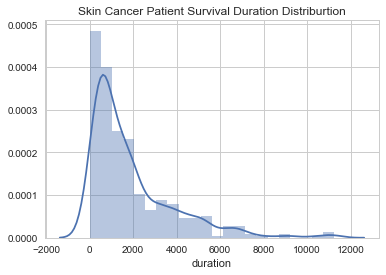

In [186]:
#Let us see the distribruation of the duration
durationsxx = df3['duration']
sns.distplot(durationsxx).set_title('Skin Cancer Patient Survival Duration Distriburtion')

### Plotting Survival Curves

Now, we can begin plotting survival curves. These curves shows the fractions of patients alive as time passes onto the end of the study. We need to understand something important about our data first, however. In our dataset, we don't know exactly when the patients actually started having cancer. We know how long it has been since they have been diagnosed with cancer and the amount of time to the end of the study or to their death. Thus, our data is known to be left censored. This is an important consideration to take into account when making survival curves and hazard curves.

Additionally, it is important to realize that for every gene mutation, we may not see survival curves for each mutation of interest complete to the end of total duration. For example, the survival curve for one mutation may end abruptly before the end of the study period. This is either because no more patients with that particular died after a certain point in the study or patient data for patients with that gene mutation stopped being collected.

Text(0, 0.5, 'Fraction of Patients Alive')

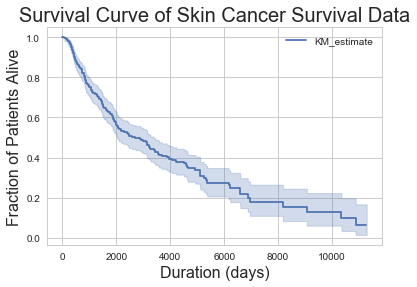

In [26]:
'''We can start performing survival analysis. We can use the Kaplan-Meier Estimate from the liflines module.
We can also find the cumulative density function of our dataset based on the two important genes.'''

#Let's make a Kaplan Meier Fitter Survival curve for the entire data set
T = df3['duration'] #we store the duration information in the dataframe T
E = df3['vital_status'] #we store the vital_status information in the dataframe E

#We will pass these dataframes to the Kaplan-Meier Estimate fitter
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  
kmf.survival_function_
kmf.median_
kmf.plot()
plt.title('Survival Curve of Skin Cancer Survival Data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0, 0.5, 'Fraction of Patients Alive')

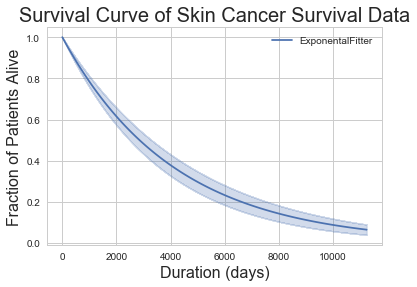

In [28]:
#We can also fit our survival curve to an exponential model. This is much smoother than the KM estimate. 
from lifelines import ExponentialFitter
exf = ExponentialFitter().fit(T, E, label='ExponentalFitter')
ax = exf.plot()
plt.title('Survival Curve of Skin Cancer Survival Data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0, 0.5, 'Fraction of Patients Alive')

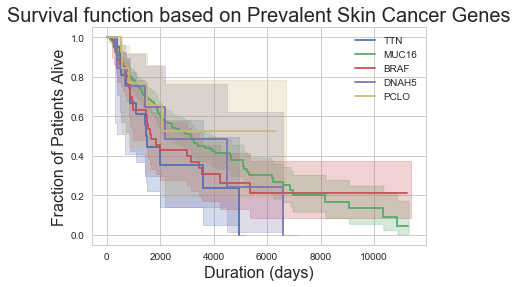

In [29]:
#Now lets plot the KMF survival curves per mutated gene. We will go ahead and plot the survival curve for each mutated gene
#and also compare them in one survival graph.


groups = df3['Hugo_Symbol'] #groups is a dataframe with the gene names

#Make the survival curve comparing important genes
ttn = (groups == 'TTN')
muc = (groups == 'MUC16')
bra = (groups == 'BRAF')
dna = (groups == 'DNAH5')
pcl = (groups == 'PCLO')

kmf.fit(T[ttn], E[ttn], label='TTN')
ax = kmf.plot()
kmf.fit(T[muc], E[muc], label='MUC16')
ax = kmf.plot(ax=ax)
kmf.fit(T[bra], E[bra], label='BRAF')
ax = kmf.plot(ax=ax)
kmf.fit(T[dna], E[dna], label='DNAH5')
ax = kmf.plot(ax=ax)
kmf.fit(T[pcl], E[pcl], label='PCLO')
ax = kmf.plot(ax=ax)
plt.title('Survival function based on Prevalent Skin Cancer Genes', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

This is a clear example of what to expect with left censored data! As we can see, patients with the DNAH5, PCLO, and TTN mutations show a survival curve that abruptly ends before the two gene mutations. This may mean that no more patients with those gene mutation died or that data for patients with that gene mutation were no longer being checked on by those who collected this data.

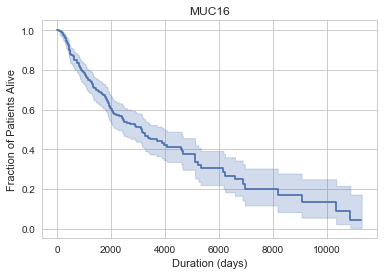

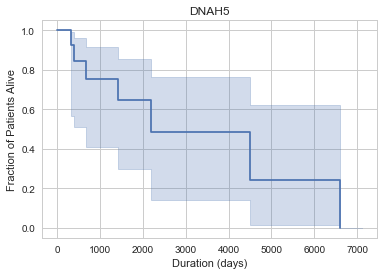

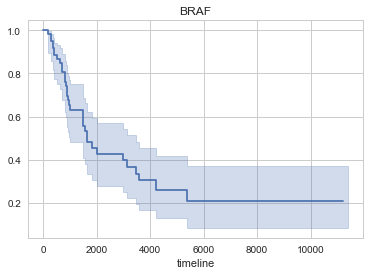

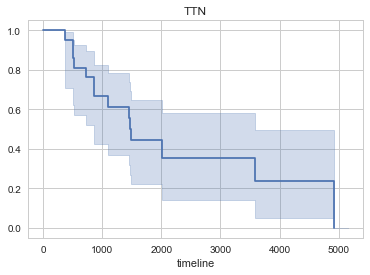

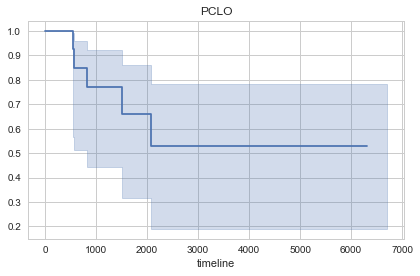

In [30]:
#We can also visualize them seperately.
mutgenes = df3['Hugo_Symbol'].unique()

for i,mg in enumerate(mutgenes):
 
    ix = df3['Hugo_Symbol'] == mg
    kmf.fit( T[ix], E[ix], label=mg)
    kmf.plot(legend=False)
    plt.title(mg)
    if i==0:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
    elif i==1:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
plt.tight_layout()

### Plotting Hazard Curves

Now let us plot the cumulative density function for our data set. This is the hazard function of our dataset, displaying the hazard or chance of death as time goes on. We don't witness the onset of the cancer, we only know how longthe patient has been alive or dead, so this is a good estimate of the hazard.

As can be seen below, as time passes on, the hazard of death, or the chance of death significantly rises.

Text(0.5, 1.0, 'Cumulative Density Function/Hazard Curve')

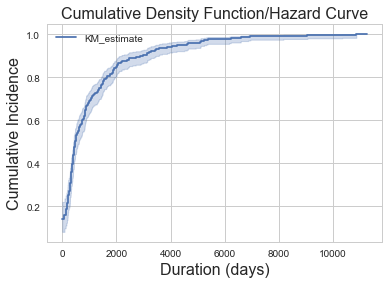

In [32]:
#Kaplan Meier Fitter plots hazard functions for survival studies if we input that left_censorship=True
kmf = KaplanMeierFitter()
kmf.fit(T, E, left_censorship=True)
kmf.plot() #will plot the CDF
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)
plt.title("Cumulative Density Function/Hazard Curve", fontsize=16)

Text(0, 0.5, 'Cumulative Incidence')

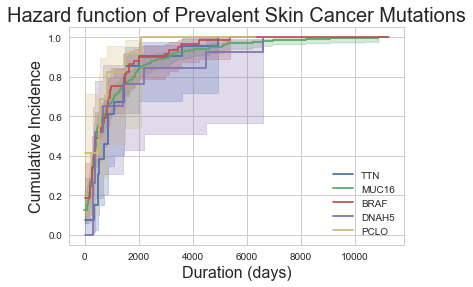

In [33]:
kmf.fit(T[ttn], E[ttn], label='TTN', left_censorship=True)
ax = kmf.plot()
kmf.fit(T[muc], E[muc], label='MUC16', left_censorship=True)
ax = kmf.plot(ax=ax)
kmf.fit(T[bra], E[bra], label='BRAF', left_censorship=True)
ax = kmf.plot(ax=ax)
kmf.fit(T[dna], E[dna], label='DNAH5', left_censorship=True)
ax = kmf.plot(ax=ax)
kmf.fit(T[pcl], E[pcl], label='PCLO', left_censorship=True)
ax = kmf.plot(ax=ax)
plt.title('Hazard function of Prevalent Skin Cancer Mutations', fontsize=20)
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)

As we can see, the three genes seem to show similar hazard curves. However, notice that the error for the DNAH5 curve is much larger than that of the others. This is probably because DNAH5's effect on patient survival varies much more greatly from patient to patient. Also notice, the curve end abruptly. It is interesting that the hazard functions are similar for all three gene mutations. This suggests that although TTN and MUC16 are the most prevelant gene mutations in patients with skin cancer, they aren't necessarily the most important gene mutation leading to death for every patient. This hazard curve may suggest that the other gene mutation may actually have as much of an effect on skin cancer patient survival as TTN and MUC16!  

Thus, our survival analysis has allowed us to see the effects of three mutated genes on skin cancer patient survival. We knew that the TTN and MUC16 gene mutations are most prevelant. However, our analysis showed us that some other gene mutations may also be of importance in skin cancer. We were able to use patient clinical data and mutation data to come to this important conclusion.


In [34]:
'''In this section, we apply a COX regression model to see if there is an assocation with survival
time of patients and their mutated gene.'''

#COX Regression Analysis
from lifelines import CoxPHFitter
df4 = df3[['Entrez_Gene_Id', 'duration', 'vital_status']]
cph = CoxPHFitter()
cph.fit(df4, duration_col='duration', event_col='vital_status', show_progress=True)

cph.print_summary()  #results


Iteration 1: norm_delta = 0.13410, step_size = 0.95000, ll = -972.61358, newton_decrement = 1.76952, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00233, step_size = 0.95000, ll = -970.92755, newton_decrement = 0.00061, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00012, step_size = 0.95000, ll = -970.92693, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 3 iterations.
<lifelines.CoxPHFitter: fitted with 415 observations, 223 censored>
      duration col = duration
         event col = vital_status
number of subjects = 415
  number of events = 192
    log-likelihood = -970.927
  time fit was run = 2019-05-18 02:30:09 UTC

---
                  coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Entrez_Gene_Id -0.0000     1.0000    0.0000 -1.8748 0.0608     -0.0000      0.0000   
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.532
Likelihood ratio test = 3.373 on 1 df, p=0.06626


As can be seen, the p value is lower than that of breast cancer. The concordance is also close to .5. This means that regardless of which of the 5 gene mutations one looks at, one generally has a random chance of determining the survival status of the skin cancer patient. This is in agreement with the conclusions we made earlier using curvival and hazard curves. 

## Machine Learning: Skin Cancer Survival Prediction

Now, we will make a few machine learning models to predict skin cancer patient survival. The purpose of this study is to determine if we can use patient tumor stage, duration, and gene mutation type to predict vital status. The value of this study is that it allows for us to determine whether or not a patient is expected to survive given their tumor stage and gene mutation. This is very important in clinical settings because it may ultimately impact the administration of life saving medications and save lives. 

Note: Since we want to determine patient survival, we are dealing with a classification problem and not a regression one. 

Three kinds of machine learning approaches will be utilized:

1. Gradient Boosting Machine: a gradient boosting machine is a decision tree based alogorithm that can be used for classification or regression purposes. Using decision trees, the model constantly adjusts predictions in order to minimize loss determined by the inputted loss function. This model is very powerful as it doesn't just fit data to a model, it also constantly updates the model using gradient descent. This is a supervised learning approach. 

2. Multilayer Perceptron: scikit-learn offers its own version of a built in neural network called MLPClassifier. It is similar to the neural network, but it is worth seeing if it can outperform the neural network made with keras. Using GridSearchCV will also help determine the best paramters for the neural network made with Keras (below).

3. Neural Network with Keras: a neural network has many layers that will approximate weights for the inputted data to ultimately reach a conclusion. The weights will be updated overtime to fit the data to the proper classifications. Neural networks can be made with any number of layers, and the ideal model varies from use case to use case. In this case, we will be doing supervised learning with a neural network. 



### Extra Data Processing

Machine learning models, including neural networks, can't work with strings. Note that the 'tumor_stage" column and "Hugo_Symbol" or "Entrez_Gene_Id" fields are also string values. Thus, they must be encoded into numbers for use in our models. Additionally, the duration time must converted to negative values for patients who are alive as positive values for duration are only meant for patients who have died. This is because the duration is means how much time has passed since death. This distinction wasn't important for our survival analysis as the lifelines library we used is able to interpret this information given vital_status. Our models won't be able to do this, so we need to preprocess our dataset to ensure our data represents proper duration times. 

In [35]:
#Notice that the duration time for both alive and dead patients are positive. However, for our later to be used cox:regression 
#GBM, we will need to see all live patients durations to negatives. 
df3a = df3
df3a.loc[df3a['vital_status'] == 0, 'duration'] *= -1
df3a.head()

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
315,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,-9188,not reported,MUC16,94025,TCGA-ER-A19G-06A-11D-A196-08
819,f027da44-6adc-4207-93ac-e8bf45a1bf3d,0,-2828,stage ib,MUC16,94025,TCGA-FR-A3YN-06A-11D-A23B-08
1484,0153f141-625e-4623-9f8a-296678002c63,1,422,stage iiia,MUC16,94025,TCGA-D3-A3ML-06A-11D-A21A-08
2528,adfa6beb-1aa3-4a2a-afe7-8d036a80b20d,0,-1229,stage ia,MUC16,94025,TCGA-WE-AAA0-06A-11D-A38G-08
2975,08d2b181-2b6e-4754-bfa9-5a94a1f18526,1,467,stage iv,MUC16,94025,TCGA-GN-A263-01A-11D-A196-08


In [36]:
df3b = df3a[['tumor_stage', 'Hugo_Symbol']] #Seperate the to be encoded columns
df3b.head()
le = preprocessing.LabelEncoder()
df3c = df3b.apply(le.fit_transform) #encoded string columns
df3c.head()

,tumor_stage,Hugo_Symbol
315,1,2
819,5,2
1484,11,2
2528,4,2
2975,14,2


In [37]:
df3d = df3a[['case_id','vital_status', 'duration']]
frames = [df3d, df3c]
res = pd.concat(frames, axis = 1)
res['vital_status'] = res['vital_status'].astype(int)
res

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol
315,90aa7540-93e7-4ffa-9e77-879198be1e7b,0,-9188,1,2
819,f027da44-6adc-4207-93ac-e8bf45a1bf3d,0,-2828,5,2
1484,0153f141-625e-4623-9f8a-296678002c63,1,422,11,2
2528,adfa6beb-1aa3-4a2a-afe7-8d036a80b20d,0,-1229,4,2
2975,08d2b181-2b6e-4754-bfa9-5a94a1f18526,1,467,14,2
3450,3d0cbbc9-f2ef-4d3e-ad55-b5cae6787c28,0,-2296,9,2
3809,ab74d6ed-880e-4470-bfd5-2974a4c3a0d7,1,1960,11,2
4082,04c3d01d-a949-4dc7-9829-a8c99180dba0,0,-411,12,2
4559,0f7ff1fc-95ec-4eb5-a308-6b8f24eec29a,0,-3733,10,2
4838,88314f23-3446-4102-a117-b65a8520d8e6,0,-1010,14,2


As can be seen above, our data has now been encoded. Since 'Entrez_Gene_Id' is really just another way to show the 'Hugo_Symbol', the latter was kept.

Upon visualizing our dataset, we can see that our dataset is MUCH MORE BALANCED than the breast cancer set. This will give us interesting results!

C:\Users\wr225\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\wr225\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of Vital Status')

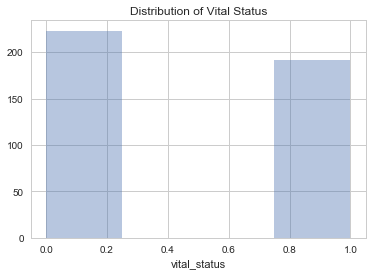

In [38]:
sns.distplot(res['vital_status'], kde=False).set_title('Distribution of Vital Status')

### Statistics Maker

Since this is a classification problem, it is important to determine three metrics: precision, recall, and the F1 Score. The precision tells us of those that are labeled as dead are actually dead. The recall tells us of those who are actually dead, how many of those we correctly predicted. The F1 score is a metric that combines precision and recall into one statistics. Specificity is another metric to consider, and it tells us: of all the people are still alive, how many we correctly predicted. Accuracy measures how many classifications were correct. When it comes to binary classifications, especially with the skewed dataset we have, accuracy doesn't tell us much about the predictive power of our models. Rather, precision, recall, and the F1 score will tell us how good our models are at properly predicting a patient's vital status. The ROC curve AUC score is also a good metric to use to determine how good of a classifier our classifier is. An AUC closer to 0.5 means a classifier that is less able to make proper binary classifications. An AUC closer to 1 indicates a good binary classifier. 

In [39]:
def statmaker(CM, arch_str, y_pred, y_test):
    TP = CM[1][1]
    TN = CM[0][0]
    FP = CM[0][1]
    FN = CM[1][0]
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    recall = TPR #sensitivity
    precision = TP/(TP + FP)
    specificity = TN/(TN + FP)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    F1 = 2*((precision*recall)/(precision + recall))
    print("True Positive Rate: " + str(TPR*100) + '%')
    print("False Positive Rate: " + str(FPR*100) + '%')
    print("Recall/Sensitivity: " + str(recall*100) + '%')
    print("Precision: " + str(precision*100) + '%')
    print("Specificity: " + str(specificity*100) + '%')
    print("Accuracy: " + str(accuracy*100) + '%')
    print("F1 Score: " + str(F1*100) + '%')
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
    plt.legend(loc=4)
    plt.title(arch_str + ' ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Tue Positive Rate')
    plt.show()
    return None
    

### Gradient Boosting Machine with XGBOOST

##### Split the data

In [89]:
'''In this section, we will use a gradient boosted model (xgboost) to see if you we can accurately determine
if a patient will survive their skin cancer based on their mutation status.'''

#First, we will specify our training and testing sets for our independent and dependent variables. Here the independent variable
#is the gene. We use the 'Hugo_Symbol' and 'tumor_stage' columns. The dependent variable is the vital_status of the patient.
X = res[['Hugo_Symbol', 'tumor_stage']]
y = res[['vital_status']]
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4) #want to use same state for proper
                                                                                               #comparison

##### Standard Classification 

In [90]:
#Here, we apply the gradient boosted model
# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=100)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=100, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

In [91]:
#Let's take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()
best_iter

37

In [92]:
#Let's retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:38:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

A feature importance plot can be made to show how much more one feature is than the other. Here, we can see that the gene type is not nearly as important in predicting patient survival as the tumor stage is. This makes sense as survival depends more so on the progression of a cancer rather than on the mutated genes leading to cancer. 

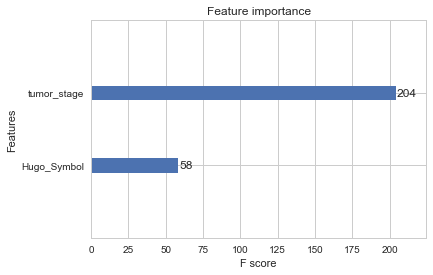

In [93]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [94]:
#Let's do a prediction
y_test_pred = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred.argmax(axis=0)
y_test_pred

array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       0.], dtype=float32)

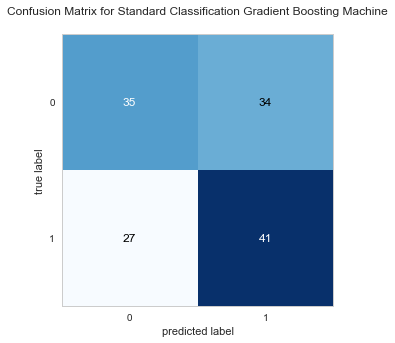

In [95]:
#Confusion Matrix
gbmloss = confusion_matrix(y_test, y_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=gbmloss ,  figsize=(5, 5))
plt.title('Confusion Matrix for Standard Classification Gradient Boosting Machine')
plt.show()

These are the statistics for the Standard Classification GBM
True Positive Rate: 60.29411764705882%
False Positive Rate: 49.275362318840585%
Recall/Sensitivity: 60.29411764705882%
Precision: 54.666666666666664%
Specificity: 50.72463768115942%
Accuracy: 55.47445255474452%
F1 Score: 57.34265734265735%


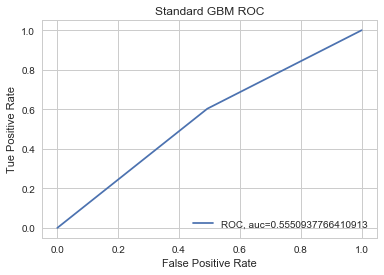

In [96]:
print('These are the statistics for the Standard Classification GBM')
statmaker(gbmloss, 'Standard GBM', y_test_pred, y_test)

The recall, precision, and F1 scores of this model are low. That means that it is a poor classifier of patient survival status based on their gene mutation and tumor stage. In fact, looking at the confusion matrix, training on this dataset with xgboost distrubuted classifications a lot. This may be because we have such few datapoints to train on. It may also be because we trained using multiple gene mutations. Regardless, it is clear that tumor stage is more important, so the number of gene mutations may not play much of a role. This model is not good for clinical use. 

### Balancing 'vital_status' to make Balanced Dataset

Given the terrible results of the gradient boosting machine shown above, I have decided to sample the dataset to get equal amounts of vital_status of 0 and 1. Thus, the dataset will be completely balanced regarding patient vital_status.

In [97]:
res1 = res[res['vital_status'] == 1] #Given that 1 appears far less often, I will use the number of 'vital_status' = 1 as data length
res1len = len(res1)
res1len

192

In [98]:
res0 = res[res['vital_status'] ==0] #sample randomly 107 samples from all 'vital_status' =0
res0 = res0.sample(n=res1len)

In [99]:
equals = [res1, res0]
res_new = pd.concat(equals)
res_new = res_new.sample(frac=1)
res_new.head() #combine and shuffle dataframe

,case_id,vital_status,duration,tumor_stage,Hugo_Symbol
106514,9f5bd948-dc3d-4b17-a114-d2f5c46fe10c,1,996,14,0
43256,b53cf25c-929c-4f1a-870e-13f260c5cf7d,0,-39,9,0
90220,2f1bbe96-49d9-417b-bc9c-a09992489340,0,-632,1,0
103801,6dc9c5b0-77e6-4c53-a75c-8f01731c54e8,0,-1197,7,2
26534,8509f10a-c454-45a5-9c22-853fda423b9f,1,2927,10,2


### Gradient Boosting Machine with Balanced Dataset

In [107]:
'''Redoing Gradient Boosting Machine with balanced dataset'''

X = res_new[['Hugo_Symbol', 'tumor_stage']]
y = res_new[['vital_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [108]:
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=100)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=100, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:41:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

In [109]:
#Let's take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()
best_iter

0

This further proves that the tumor_stage is more important in determining patient survival than the gene mutation at hand.

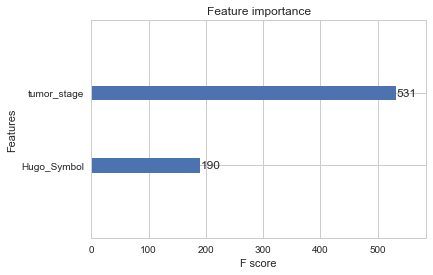

In [110]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [111]:
#Let's do a prediction
y_test_pred_e = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred_e.argmax(axis=0)
y_test_pred_e

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0.], dtype=float32)

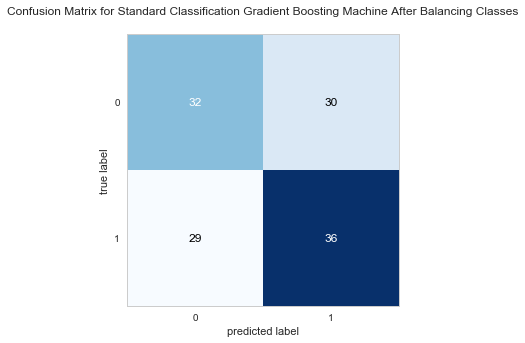

In [112]:
#Confusion Matrix
gbmloss_e = confusion_matrix(y_test, y_test_pred_e)
fig, ax = plot_confusion_matrix(conf_mat=gbmloss_e ,  figsize=(5, 5))
plt.title('Confusion Matrix for Standard Classification Gradient Boosting Machine After Balancing Classes')
plt.show()

These are the statistics for the Standard Classification GBM After Balancing Classes
True Positive Rate: 55.38461538461539%
False Positive Rate: 48.38709677419355%
Recall/Sensitivity: 55.38461538461539%
Precision: 54.54545454545454%
Specificity: 51.61290322580645%
Accuracy: 53.54330708661418%
F1 Score: 54.961832061068705%


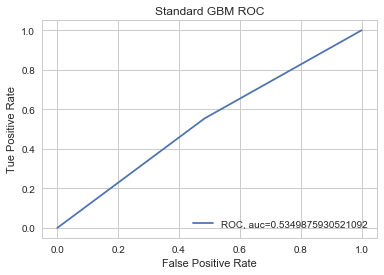

In [113]:
print('These are the statistics for the Standard Classification GBM After Balancing Classes')
statmaker(gbmloss_e, 'Standard GBM', y_test_pred_e, y_test)

##### Not much improvement!

After balancing the dataset, it is clear that the F1 Score, Recall, and Precision didn't really change all too much. This may be because the original dataset wasn't very skewed in the first place. The AUC actually went down after balancing the dataset, suggesting this model actually now performs worse than before. 

The model performance can definitely be improved with the use of more datapoints. Thus, it is important to gather thousands of data points to train such a model before putting it into clinical use. Regardless, these results are not promising regarding the use of GBM for skin cancer survival status prediction.

##### COX Regression Based Classification

The COX Regression Objective allows us to make classication based on survival time ('duration' in our case). Thus, now we can use the modified 'duration' column to also make predictions. The result of the following model won't be useful clinically as it requires patient survival times, but it does assess how well one can determine patient survival status based on duration/survival time.

In [138]:
#Need to add duration column for COX Regression based classification
X = res[['Hugo_Symbol', 'tumor_stage', 'duration']]
y = res[['vital_status']]
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4) 


#Here, we apply the gradient boosted model

# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 3,
    "objective": "survival:cox",
    "eval_metric": "logloss",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(10)])

[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

As expected for COX Regression based classification, duration is by far the most important feature for predictions. However, we can see here that the importance of which gene is mutated in a patient is much closer to that of the tumor stage than it was for the simple classification done earlier. This suggests that when patient survival time is taken into account, the type of mutation a patient has is more important than when not considering survival time.

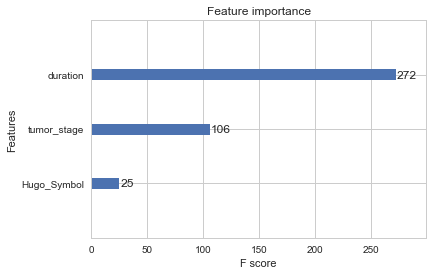

In [139]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel)

In [140]:
#Let's do a prediction
y_test_pred = xgbmodel.predict(xgb.DMatrix(X_test))
# Generate class prediction based on max probability
y_test_pred_class = y_test_pred.argmax(axis=0)

In [141]:
#Accuracy of our prediction
print("Accuracy with GBM: ")
a = (y_test_pred_class == y_test).mean()
print(a)

Accuracy with GBM: 
vital_status    0.50365
dtype: float64


As we can see with the survival:cox objective, we got an accuracy of 50%. Thus, our model is not very good at determining survival status of patients based on their survival time, mutated gene, and tumor stage. Note that the accuracy on our breast cancer dataset was much higher. This change suggests that this model works better on one dataset than another. This renders this model not as reusable as one would like. Since patient 'duration' is an end of study feature, including it doesn't really help make patient survival predictive models. 

### MLPClassifier

The MLP Classifier is scikit-learn's own neural network model. It is a good way to determine the number of layers that should be used in the Keras based neural network to be developed after.  

In [142]:
#Need to specify the features to be used again. 
X = res[['Hugo_Symbol', 'tumor_stage']]
y = res[['vital_status']].values.ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)


In [143]:
#Since I want to determine the best parameters to use for my own neural network after, I will use GridSearch CV on the 
#MLPClassifier for effecient determination of good parameters.

parameters={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(64,2), (32,2), (16,2), (8,2)],
'alpha': 10.0 ** -np.arange(1, 5),
'activation': ["logistic", "relu", "tanh"]
}

nnclf= GridSearchCV(estimator=MLPClassifier(),param_grid=parameters,verbose=2,cv=3)

In [144]:
nnclf.fit(X_train, y_train)                         

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), lear

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hi

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activat

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activat

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  act

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=log

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscal

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adapt

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  ac

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), lea

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learnin

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), l

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), 

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), l

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_si

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_la

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_s

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.00

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), lea

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), lea

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64,

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_size

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_l

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   26.6s finished
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(64, 2), (32, 2), (16, 2), (8, 2)], 'alpha': array([0.1   , 0.01  , 0.001 , 0.0001]), 'activation': ['logistic', 'relu', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [145]:
print(nnclf.best_params_)

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (8, 2), 'learning_rate': 'invscaling'}


These are the parameters I will base my Keras based neural network off of. 

In [146]:
y_pred_mlp = nnclf.predict(X_test)
y_pred_mlp

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

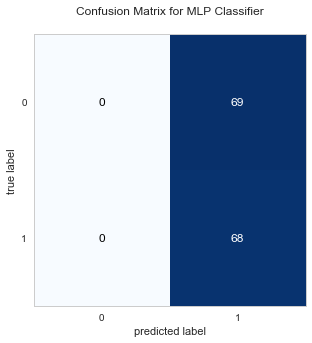

In [147]:
#Confusion Matrix
mlp_cm = confusion_matrix(y_test, y_pred_mlp)
fig, ax = plot_confusion_matrix(conf_mat=mlp_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

These are the statistics for the MLP Classifier
True Positive Rate: 100.0%
False Positive Rate: 100.0%
Recall/Sensitivity: 100.0%
Precision: 49.63503649635037%
Specificity: 0.0%
Accuracy: 49.63503649635037%
F1 Score: 66.34146341463415%


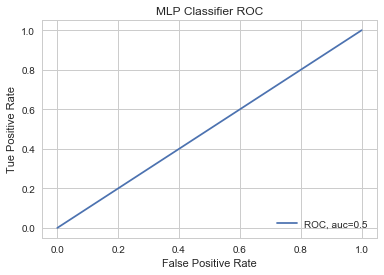

In [148]:
print('These are the statistics for the MLP Classifier')
statmaker(mlp_cm, 'MLP Classifier', y_pred_mlp, y_test)

The MLP Classifier did extremely poorly as it classified every patient in the test set with a 'vital_status' of 1. The metric scores like F1 and recall don't mean much here because the model simply classified everything as having a status of 1. This may be because the MLPclassifier does poorly on a few number of datapoints. Neural networks work really well on a large number of datapoints. Thus, the few datapoints in this dataset don't allow the MLP Classifier to learn well.

Time to use the balanced data set!

### MLPClassifier with Balanced Dataset

In [149]:
X = res_new[['Hugo_Symbol', 'tumor_stage']]
y = res_new[['vital_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [150]:
parameters={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(64,2), (32,2), (16,2), (8,2)],
'alpha': 10.0 ** -np.arange(1, 5),
'activation': ["logistic", "relu", "tanh"]
}

nnclf_e= GridSearchCV(estimator=MLPClassifier(),param_grid=parameters,verbose=2,cv=3)

In [151]:
nnclf_e.fit(X_train, y_train)    

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logist

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.1, hi

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activatio

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logist

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  act

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activat

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  acti

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscal

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adapt

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_la

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.00

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=relu, alpha=0.0001, hidden_l

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), l

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(16, 2), lea

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), lea

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hi

C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was pass

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(16, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=constant, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling 


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=invscaling, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(8, 2), learning_rate=adaptive, total=   0.0s


C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   26.4s finished
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\wr225\Anaconda3\lib\site-packages\sklearn\neural_

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(64, 2), (32, 2), (16, 2), (8, 2)], 'alpha': array([0.1   , 0.01  , 0.001 , 0.0001]), 'activation': ['logistic', 'relu', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [152]:
print(nnclf_e.best_params_)

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 2), 'learning_rate': 'constant'}


In [153]:
y_pred_mlp_e = nnclf_e.predict(X_test)
y_pred_mlp_e

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])

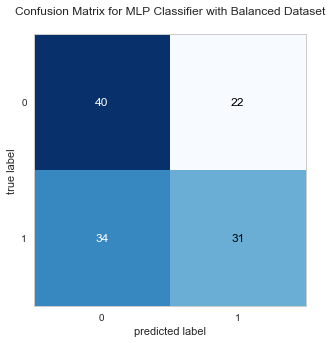

In [154]:
#Confusion Matrix
mlp_e_cm = confusion_matrix(y_test, y_pred_mlp_e)
fig, ax = plot_confusion_matrix(conf_mat=mlp_e_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for MLP Classifier with Balanced Dataset')
plt.show()

These are the statistics for the MLP Classifier
True Positive Rate: 47.69230769230769%
False Positive Rate: 35.483870967741936%
Recall/Sensitivity: 47.69230769230769%
Precision: 58.490566037735846%
Specificity: 64.51612903225806%
Accuracy: 55.90551181102362%
F1 Score: 52.54237288135594%


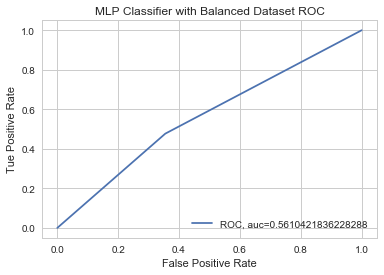

In [155]:
print('These are the statistics for the MLP Classifier')
statmaker(mlp_e_cm, 'MLP Classifier with Balanced Dataset', y_pred_mlp_e, y_test)

##### More success?

The performance of the MLPClassifier improved overall when trained on the balanced dataset. Notice from the confusion matrix that, this time around, the classifier was able to classify some patients have vital_status of 0 as actually 0. This is so far the best classifier based on the AUC score.This model can be improved by using more data points to train. Neural networks perform far better on more data points than was used here. 

Let's now onto the Keras based Neural Network.

### Keras Based Neural Network

Keras is a Python Deep Learning library that will be used to build a neural network. The ideal paramters for this neural network will be based off of the paramters decided by using the MLPClassifier from scikit-learn.

Neural networks are best suited for a large number of data points. Therefore, it may not be ideal here as we are dealing with less than 1000 patients. However, it is still worthwhile to examine the effectiveness of neural networks in analyzing clinical data. If the neural network is able to predict vital status with reasonable accuracy, then it may be useful for analyzing larger number of patients with cancer. 

In [158]:
#We need to convert the labels to categorical labels
from keras.utils import to_categorical

X = res[['Hugo_Symbol', 'tumor_stage']]
y = res[['vital_status']].values.ravel()
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [159]:
'''We will be using the Sequential Model with the tanh activation function, a layer of size 8 and a layer of size 2, an 
additional softmax layer, and an adaptive activation function, RMSprop. These choices are based on the GridSearchCV of the 
MLPClassifier without the balanced dataset'''

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(2,))) #First layer with 8 units
model.add(Dense(2, activation='relu')) #Second layer with 2 units, softmax is used 
model.add(Dense(2, activation='softmax')) #Additional layer
model.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='binary_crossentropy', #Binary classification
              metrics=['accuracy'])

print("These are the layers of the model:")
model.summary()

These are the layers of the model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 6         
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [160]:
#Training step
model.fit(
    X, 
    y, 
    batch_size=32, 
    epochs=10, verbose=2, 
    callbacks=None, 
    validation_split=0.33, 
    validation_data=None, 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0)

Train on 278 samples, validate on 137 samples
Epoch 1/10
 - 0s - loss: 0.9785 - acc: 0.5432 - val_loss: 0.7647 - val_acc: 0.5912
Epoch 2/10
 - 0s - loss: 0.8908 - acc: 0.5324 - val_loss: 0.7304 - val_acc: 0.6058
Epoch 3/10
 - 0s - loss: 0.8382 - acc: 0.5324 - val_loss: 0.7087 - val_acc: 0.6058
Epoch 4/10
 - 0s - loss: 0.7993 - acc: 0.5144 - val_loss: 0.6961 - val_acc: 0.6277
Epoch 5/10
 - 0s - loss: 0.7707 - acc: 0.5216 - val_loss: 0.6903 - val_acc: 0.6204
Epoch 6/10
 - 0s - loss: 0.7503 - acc: 0.5324 - val_loss: 0.6880 - val_acc: 0.5693
Epoch 7/10
 - 0s - loss: 0.7355 - acc: 0.5360 - val_loss: 0.6876 - val_acc: 0.5693
Epoch 8/10
 - 0s - loss: 0.7272 - acc: 0.5252 - val_loss: 0.6889 - val_acc: 0.4964
Epoch 9/10
 - 0s - loss: 0.7232 - acc: 0.4856 - val_loss: 0.6906 - val_acc: 0.4964
Epoch 10/10
 - 0s - loss: 0.7194 - acc: 0.4748 - val_loss: 0.6908 - val_acc: 0.4891


In [161]:
#Make Predictions
y_keras = model.predict_classes(X_test)
y_keras

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1], dtype=int64)

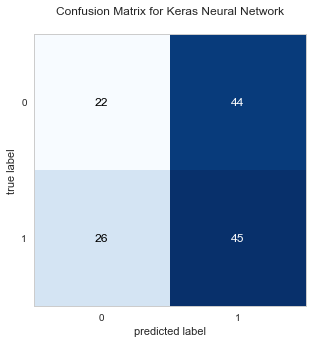

In [162]:
#Reinitialize y_test for us in confusion matrix due to the mismatch in type of y_keras
y = res[['vital_status']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

#Confusion Matrix
y_keras_cm = confusion_matrix(y_test, y_keras)
fig, ax = plot_confusion_matrix(conf_mat=y_keras_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Keras Neural Network')
plt.show()

These are the statistics for the Keras Neural Network
True Positive Rate: 63.38028169014085%
False Positive Rate: 66.66666666666666%
Recall/Sensitivity: 63.38028169014085%
Precision: 50.56179775280899%
Specificity: 33.33333333333333%
Accuracy: 48.9051094890511%
F1 Score: 56.25%


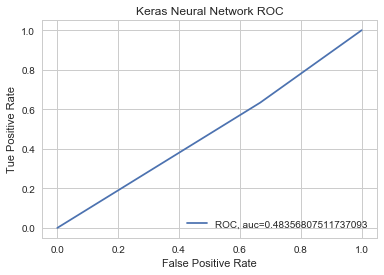

In [163]:
print('These are the statistics for the Keras Neural Network')
statmaker(y_keras_cm, 'Keras Neural Network', y_keras, y_test)

Using similar paramters as the best model from the MLPClassifier trained on the unbalanced dataset, this neural network did fairly poorly  in all regards. Notice how it classified almost as many patients correctly as 1 as it classified them incorrectly as 1. A similar trend exists for the classification to 0.

### Keras Neural Network with Balanced Dataset

In [164]:
X = res_new[['Hugo_Symbol', 'tumor_stage']]
y = res_new[['vital_status']]
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [165]:
modelb = Sequential()
modelb.add(Dense(32, activation='relu', input_shape=(2,))) #First layer with 8 units
modelb.add(Dense(2, activation='relu')) #Second layer with 2 units, softmax is used 
modelb.add(Dense(2, activation='softmax')) #Additional layer
modelb.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='binary_crossentropy', #Binary classification
              metrics=['accuracy'])

print("These are the layers of the model:")
modelb.summary()

These are the layers of the model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 6         
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


In [166]:
#Training step
modelb.fit(
    X, 
    y, 
    batch_size=32, 
    epochs=10, verbose=2, 
    callbacks=None, 
    validation_split=0.33, 
    validation_data=None, 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0)

Train on 257 samples, validate on 127 samples
Epoch 1/10
 - 0s - loss: 0.6942 - acc: 0.5389 - val_loss: 0.6932 - val_acc: 0.5118
Epoch 2/10
 - 0s - loss: 0.6948 - acc: 0.5292 - val_loss: 0.6938 - val_acc: 0.5118
Epoch 3/10
 - 0s - loss: 0.6951 - acc: 0.5253 - val_loss: 0.6940 - val_acc: 0.4882
Epoch 4/10
 - 0s - loss: 0.6947 - acc: 0.5097 - val_loss: 0.6922 - val_acc: 0.5276
Epoch 5/10
 - 0s - loss: 0.6924 - acc: 0.5409 - val_loss: 0.6920 - val_acc: 0.5197
Epoch 6/10
 - 0s - loss: 0.6927 - acc: 0.5370 - val_loss: 0.6919 - val_acc: 0.5118
Epoch 7/10
 - 0s - loss: 0.6938 - acc: 0.5292 - val_loss: 0.6929 - val_acc: 0.5118
Epoch 8/10
 - 0s - loss: 0.6941 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5197
Epoch 9/10
 - 0s - loss: 0.6929 - acc: 0.5214 - val_loss: 0.6920 - val_acc: 0.5118
Epoch 10/10
 - 0s - loss: 0.6928 - acc: 0.5253 - val_loss: 0.6920 - val_acc: 0.5276


In [167]:
#Make Predictions
y_keras_e = modelb.predict_classes(X_test)
y_keras_e

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

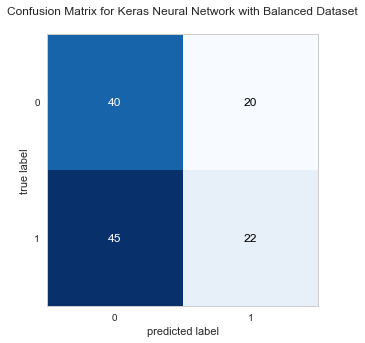

In [168]:
#Reinitialize y_test for us in confusion matrix due to the mismatch in type of y_keras
y = res_new[['vital_status']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=35)

#Confusion Matrix
y_keras_e_cm = confusion_matrix(y_test, y_keras_e)
fig, ax = plot_confusion_matrix(conf_mat=y_keras_e_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Keras Neural Network with Balanced Dataset')
plt.show()

These are the statistics for the Keras Neural Network
True Positive Rate: 32.83582089552239%
False Positive Rate: 33.33333333333333%
Recall/Sensitivity: 32.83582089552239%
Precision: 52.38095238095239%
Specificity: 66.66666666666666%
Accuracy: 48.818897637795274%
F1 Score: 40.36697247706422%


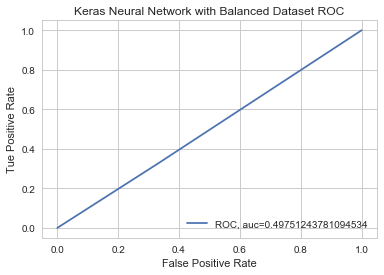

In [169]:
print('These are the statistics for the Keras Neural Network')
statmaker(y_keras_e_cm, 'Keras Neural Network with Balanced Dataset', y_keras_e, y_test)

##### No success for skin cancer!

This neural net also performed very poorly like the last one. This final model makes it clear that what was to blame for low performance in classifying skin cancer was not the skew in the dataset. It was really the number of datapoints available to us. Since the balanced dataset uses under 400 data points, there is not sufficient learning on any of these models. 

Will neural networks be useful in clinical situations? If they are trained on many more data points(thousands to millions), they can be amazing classifiers. Neural networks are often used for image classification in the cinical setting, so their value in patient survival classification may be of great use to clinicians. However, clincians may prefer more interpretable models.

## Conclusions

The survival analysis portion of this study demonstrated that the TTN, MUC16, BRAF, DNAH5, and PCLO gene mutations may actually be of significant interest to clincians for the treastment of skin cancer. There weren't any remarkable findings with this dataset. 

The machine learning compononent of this project provided some interesting insights into how data composition and size can ultimately impact model strength. This skin cancer dataset was clearly very different from the breast cancer dataset. Not only were there much fewer datapoints to train with, but the dataset was more balanced. The same models were used in the analysis and classification modeling of both datasets. However, very different results were obtained. Even though the breast cancer dataset was far more skewed than this one, the models were able to become better classifiers on breast cancer data than on skin cancer data. The MLPClassifier trained on the balanced dataset is the best classifier given its AUC score. 

I believe that the huge discrepancy in predictive power mainly lies in the small number of datapoints available in the skin cancer dataset. Machine learning models require the use of many data points to come to useful predictions. This further drives home the point that, in order for machine learning to be useful in clinical settings, models must be trained on a large number of data points. 